In [23]:
import pandas as pd
import numpy as np
import seaborn as sns

In [24]:
orders = pd.read_csv('https://raw.githubusercontent.com/vladkutyanov/metrics-hw1/main/hw1/orders.csv')
customers = pd.read_csv('https://raw.githubusercontent.com/vladkutyanov/metrics-hw1/main/hw1/customers.csv')

In [25]:
customers.rename(columns={'id': 'customer_id'}, inplace=True)

In [26]:
df = pd.merge(orders, customers, how = 'left', on = 'customer_id')

In [27]:
df

,id,order_date,ship_mode,customer_id,sales,name,segment,state,city
0,100006,2014-09-07,Standard,DK-13375,377.970,Dennis Kane,Consumer,Ohio,Marion
1,100090,2014-07-08,Standard,EB-13705,699.192,Ed Braxton,Corporate,Ohio,Akron
2,100293,2014-03-14,Standard,NF-18475,91.056,Neil Franzosisch,Home Office,Illinois,Rockford
3,100328,2014-01-28,Standard,JC-15340,3.928,Jasper Cacioppo,Consumer,California,Los Angeles
4,100363,2014-04-08,Standard,JM-15655,21.376,Jim Mitchum,Corporate,New Jersey,Bridgeton
...,...,...,...,...,...,...,...,...,...
5004,168802,2017-11-03,Standard,JO-15145,18.368,Jack O'Briant,Corporate,Pennsylvania,Philadelphia
5005,169320,2017-07-23,Second,LH-16900,171.430,Lena Hernandez,Consumer,Delaware,Dover
5006,169488,2017-09-07,First,AA-10375,56.860,Allen Armold,Consumer,Arizona,Mesa
5007,169502,2017-08-28,Standard,MG-17650,113.410,Matthew Grinstein,Home Office,Pennsylvania,Philadelphia


Построим хитмэп для всех покупателей.

In [28]:
df['order_date'] = pd.to_datetime(df['order_date'],infer_datetime_format=True)
df['order_month'] = df['order_date'].dt.strftime('%Y-%m') 
cohorts= df.groupby('customer_id',as_index=False)['order_month'].min()
cohorts.rename(columns = {'order_month':'cohort'},inplace=True)
df_cohorts= pd.merge(df, cohorts, how='left', on='customer_id')

In [29]:
df_cohorts

,id,order_date,ship_mode,customer_id,sales,name,segment,state,city,order_month,cohort
0,100006,2014-09-07,Standard,DK-13375,377.970,Dennis Kane,Consumer,Ohio,Marion,2014-09,2014-09
1,100090,2014-07-08,Standard,EB-13705,699.192,Ed Braxton,Corporate,Ohio,Akron,2014-07,2014-07
2,100293,2014-03-14,Standard,NF-18475,91.056,Neil Franzosisch,Home Office,Illinois,Rockford,2014-03,2014-03
3,100328,2014-01-28,Standard,JC-15340,3.928,Jasper Cacioppo,Consumer,California,Los Angeles,2014-01,2014-01
4,100363,2014-04-08,Standard,JM-15655,21.376,Jim Mitchum,Corporate,New Jersey,Bridgeton,2014-04,2014-04
...,...,...,...,...,...,...,...,...,...,...,...
5004,168802,2017-11-03,Standard,JO-15145,18.368,Jack O'Briant,Corporate,Pennsylvania,Philadelphia,2017-11,2014-01
5005,169320,2017-07-23,Second,LH-16900,171.430,Lena Hernandez,Consumer,Delaware,Dover,2017-07,2014-08
5006,169488,2017-09-07,First,AA-10375,56.860,Allen Armold,Consumer,Arizona,Mesa,2017-09,2014-04
5007,169502,2017-08-28,Standard,MG-17650,113.410,Matthew Grinstein,Home Office,Pennsylvania,Philadelphia,2017-08,2014-08


In [30]:
def cohort_period(df):
    """
    Creates column cohort_period
    """
    df['cohort_period'] = np.arange(len(df))
    return df

Смотрим на коэффициент удержания в 2014-15 годах.

In [31]:
cohorts_group = df_cohorts[(df_cohorts['cohort'] <= '2016-01') & (df_cohorts['order_date'] <= '2016-01')].groupby(['cohort', 'order_month']).agg({'customer_id': pd.Series.nunique})
cohorts_group.rename(columns={'customer_id': 'total_users',
                        'id': 'total_orders'}, inplace=True)
cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
cohorts_group.reset_index(inplace=True)
cohorts_group.set_index(['cohort', 'cohort_period'], inplace=True) 
cohort_group_size = cohorts_group['total_users'].groupby(level=0).first()
user_retention = cohorts_group['total_users'].unstack(0).divide(cohort_group_size, axis=1)

In [35]:
user_retention.fillna(0, inplace = True)

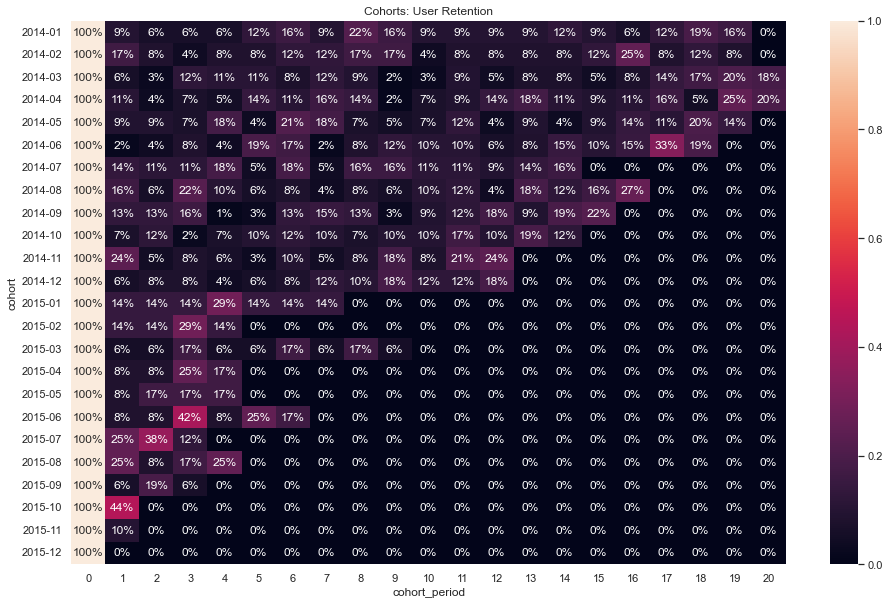

In [36]:
sns.set(style='white')
plt.figure(figsize=(16, 10))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

Смотрим на коэффициент удержания с 2016 года 

In [38]:
cohorts_group = df_cohorts[(df_cohorts['cohort'] >= '2016-01') & (df_cohorts['order_date'] >= '2016-01')].groupby(['cohort', 'order_month']).agg({'customer_id': pd.Series.nunique})
cohorts_group.rename(columns={'customer_id': 'total_users',
                        'id': 'total_orders'}, inplace=True)
cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
cohorts_group.reset_index(inplace=True)
cohorts_group.set_index(['cohort', 'cohort_period'], inplace=True) 
cohort_group_size = cohorts_group['total_users'].groupby(level=0).first()
user_retention = cohorts_group['total_users'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.fillna(0, inplace = True)

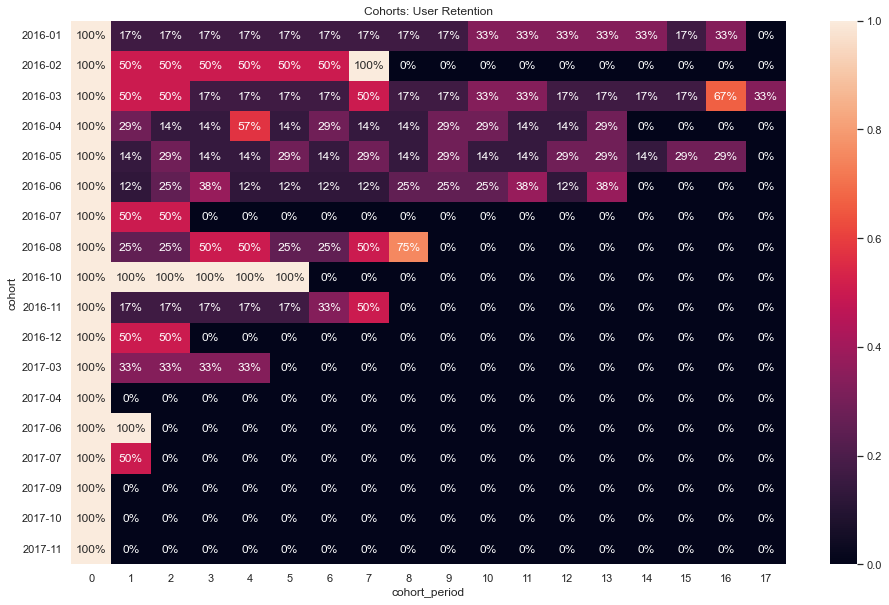

In [39]:
sns.set(style='white')
plt.figure(figsize=(16, 10))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

На всем промежутке.

In [40]:
cohorts_group = df_cohorts.groupby(['cohort', 'order_month']).agg({'customer_id': pd.Series.nunique})
cohorts_group.rename(columns={'customer_id': 'total_users',
                        'id': 'total_orders'}, inplace=True)
cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
cohorts_group.reset_index(inplace=True)
cohorts_group.set_index(['cohort', 'cohort_period'], inplace=True) 
cohort_group_size = cohorts_group['total_users'].groupby(level=0).first()
user_retention = cohorts_group['total_users'].unstack(0).divide(cohort_group_size, axis=1)

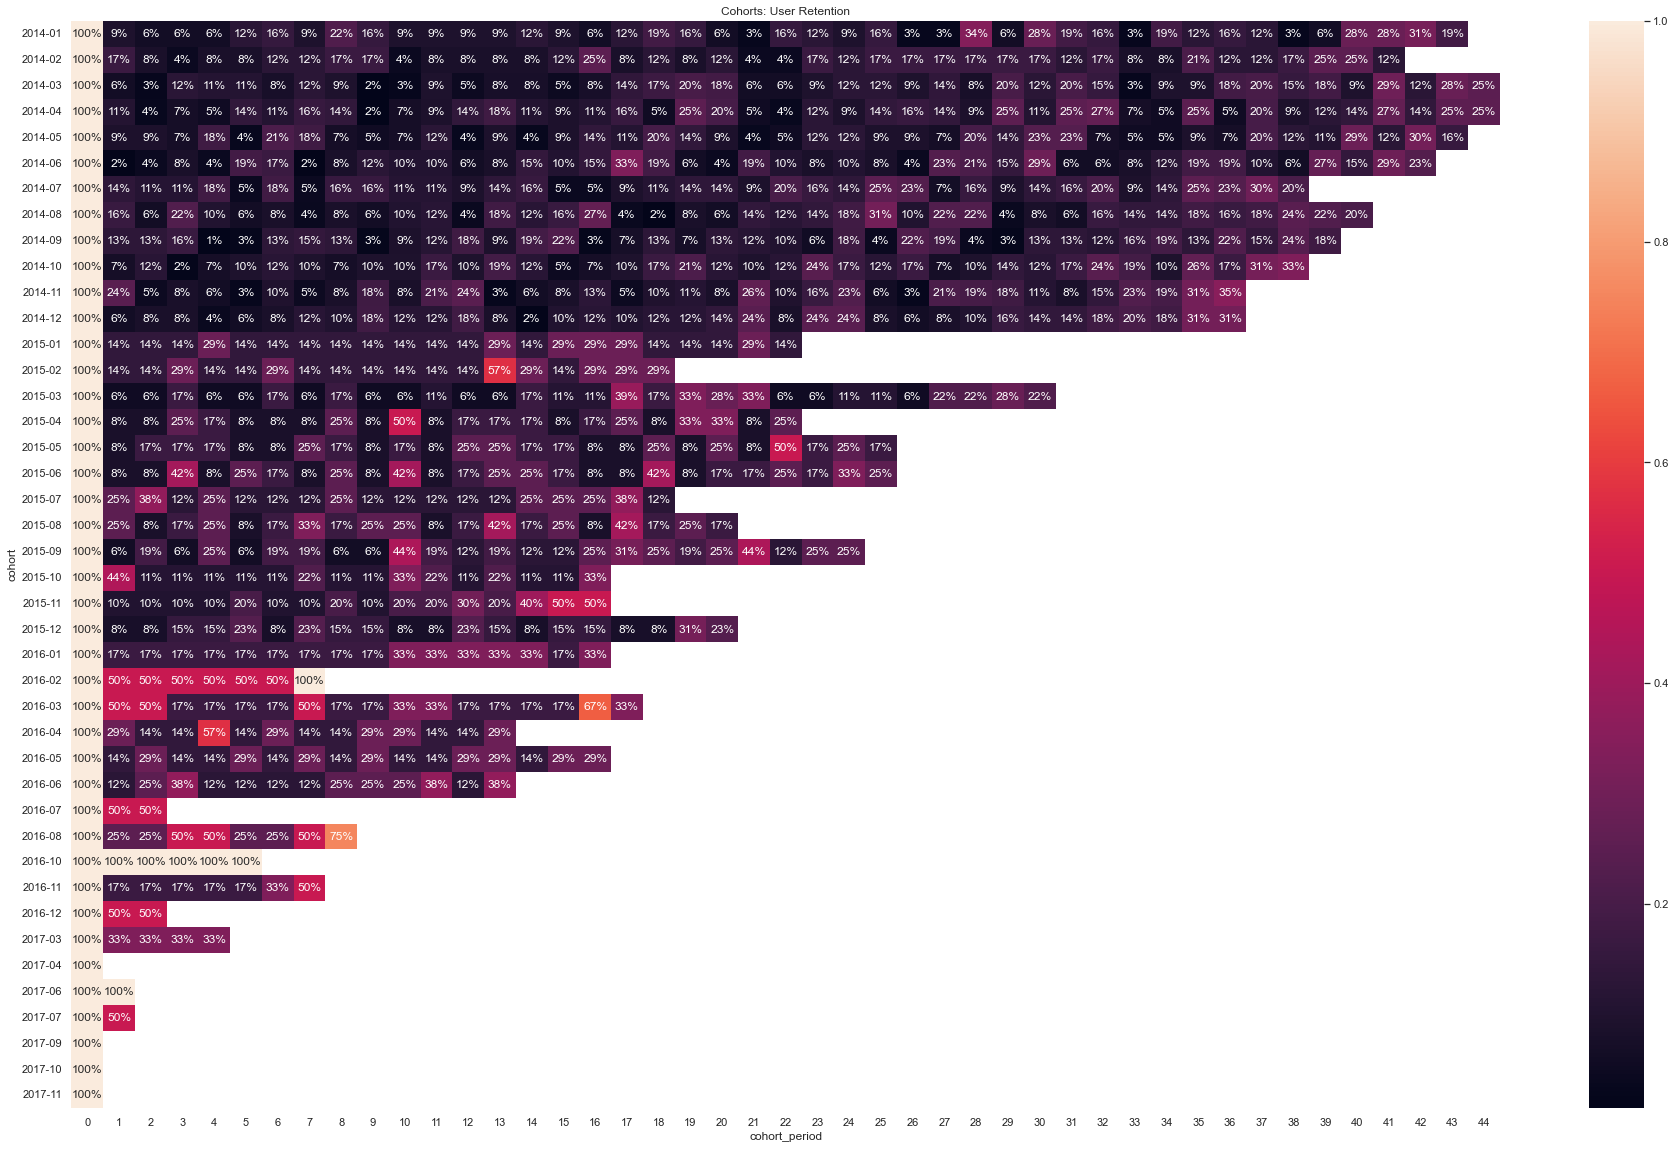

In [42]:
sns.set(style='white')
plt.figure(figsize=(32, 20))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

Графически неочевидно, что коэффициент удержания со временем падает, скорее наоборот. Плюс для совсем старых пользователей он начинает расти только по прошествии большого количества времени, так что, **возможно, дело не в доставке, а в чем-то другом, например, типе товаров**. Посмотрим на удержания для типа покупателя "Consumer".

In [43]:
df_cons = df[df['segment'] == 'Consumer']
df_cons['order_date'] = pd.to_datetime(df_cons['order_date'],infer_datetime_format=True)
df_cons['order_month'] = df_cons['order_date'].dt.strftime('%Y-%m') 
cohorts= df_cons.groupby('customer_id',as_index=False)['order_month'].min()
cohorts.rename(columns = {'order_month':'cohort'},inplace=True)
df_cohorts= pd.merge(df_cons, cohorts, how='left', on='customer_id')

In [44]:
cohorts_group = df_cohorts.groupby(['cohort', 'order_month']).agg({'customer_id': pd.Series.nunique})
cohorts_group.rename(columns={'customer_id': 'total_users',
                        'id': 'total_orders'}, inplace=True)
cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
cohorts_group.reset_index(inplace=True)
cohorts_group.set_index(['cohort', 'cohort_period'], inplace=True) 
cohort_group_size = cohorts_group['total_users'].groupby(level=0).first()
user_retention = cohorts_group['total_users'].unstack(0).divide(cohort_group_size, axis=1)

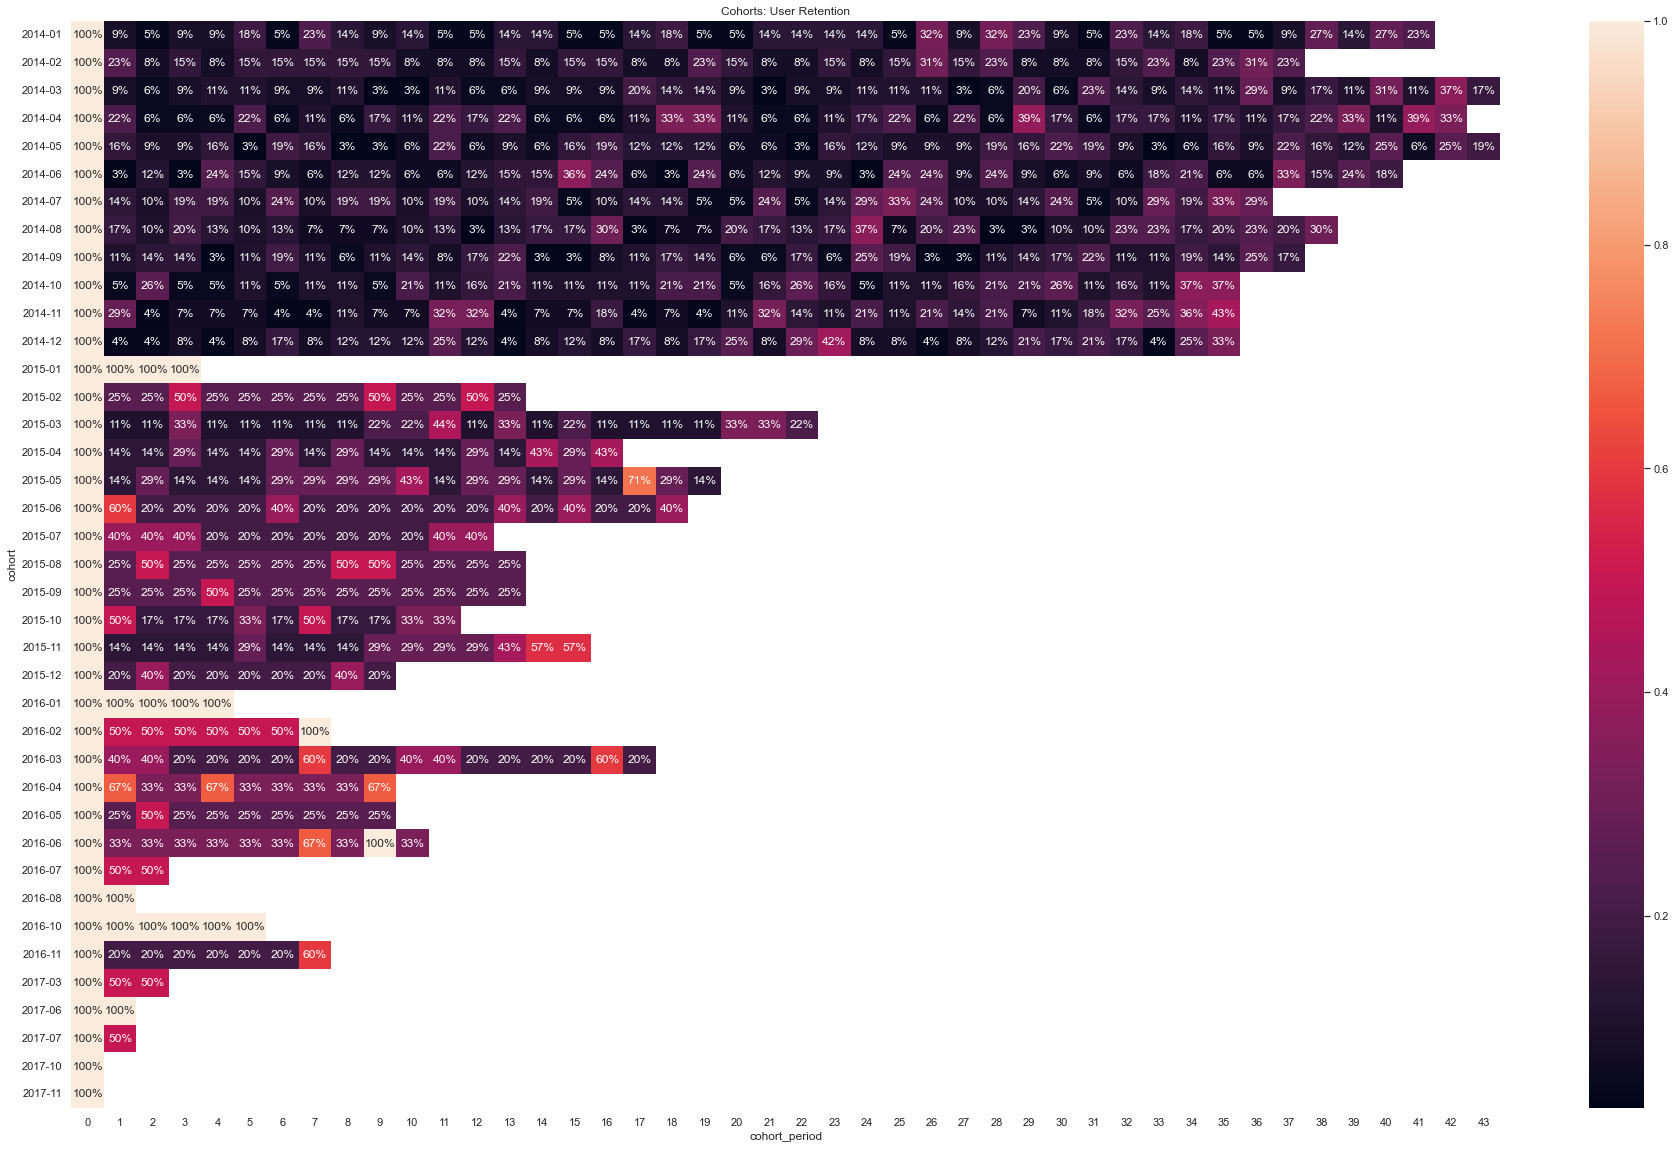

In [45]:
sns.set(style='white')
plt.figure(figsize=(32, 20))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

Картина похожая: коэффициент удержания увеличивается только после большого количества времени. Смотрим для всех остальных типов.

In [58]:
df_nocons = df[df['segment'] != 'Consumer']
df_nocons['order_date'] = pd.to_datetime(df_nocons['order_date'],infer_datetime_format=True)
df_nocons['order_month'] = df_nocons['order_date'].dt.strftime('%Y-%m') 
cohorts= df_nocons.groupby('customer_id',as_index=False)['order_month'].min()
cohorts.rename(columns = {'order_month':'cohort'},inplace=True)
df_cohorts= pd.merge(df_nocons, cohorts, how='left', on='customer_id')

In [59]:
cohorts_group = df_cohorts.groupby(['cohort', 'order_month']).agg({'customer_id': pd.Series.nunique})
cohorts_group.rename(columns={'customer_id': 'total_users',
                        'id': 'total_orders'}, inplace=True)
cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
cohorts_group.reset_index(inplace=True)
cohorts_group.set_index(['cohort', 'cohort_period'], inplace=True) 
cohort_group_size = cohorts_group['total_users'].groupby(level=0).first()
user_retention = cohorts_group['total_users'].unstack(0).divide(cohort_group_size, axis=1)

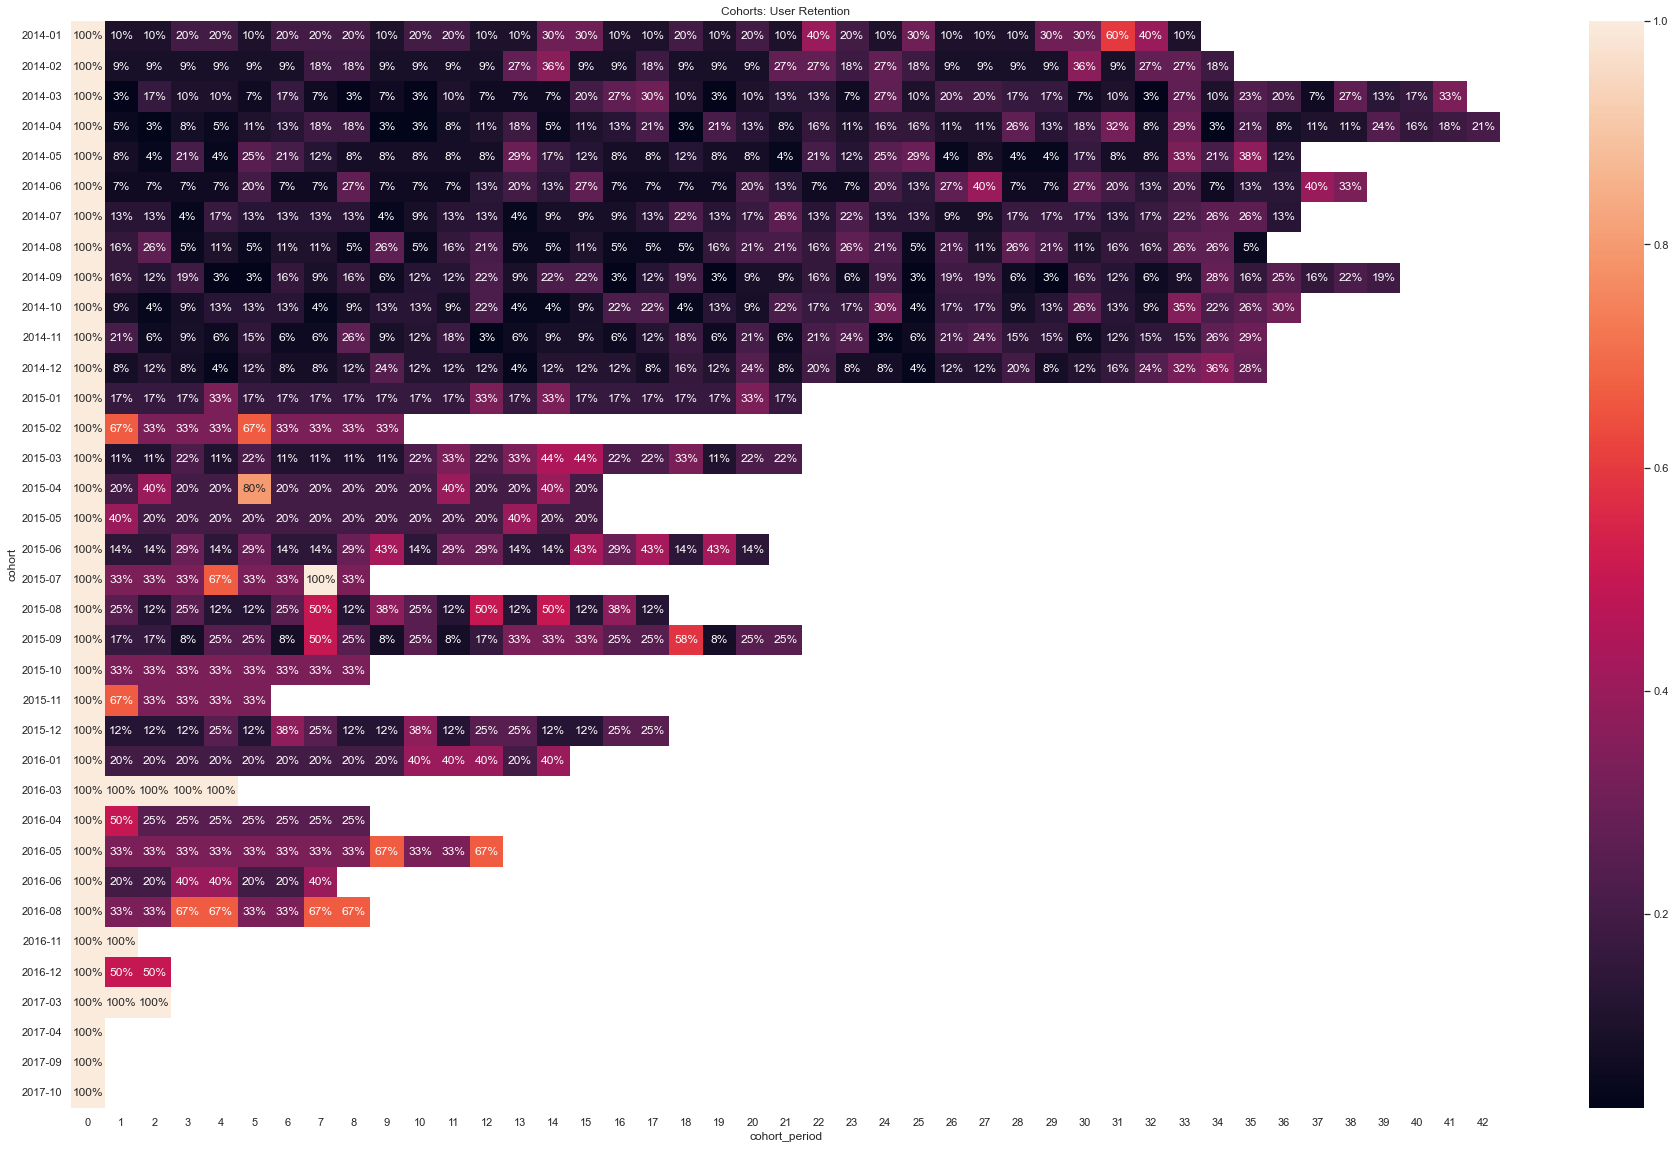

In [60]:
sns.set(style='white')
plt.figure(figsize=(32, 20))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

Видим то же самое: коэффициент отказа растет только по прошествии большого количества времени. Можно заключить, что доставка не повлияла на коэффициент.